# Assigment 4: Clustersing - Digits Dataset - External Indices

Joseph Nelson Farrell  
DS 5230 Unsupervised Machine Learning  
Professor Stevin Morin, PhD  
03-30-24  

___

### Import Libraries

In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os  
from pathlib import Path

from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics.cluster import contingency_matrix, adjusted_rand_score

from scipy.stats import mode

import math

%matplotlib inline
sns.set(style = 'white', context = 'notebook', rc = {'figure.figsize': (14,  10)})

import warnings
warnings.filterwarnings("ignore")

___

### Set Path

In [2]:
# set path, this will will used for saving figures
path = Path(os.getcwd())
path = str(path)

____

### Import Functions

In [3]:
from clustering_utils import get_nn_dist
from clustering_utils import generate_hopkins_statistic
from clustering_utils import find_elbow
from clustering_utils import get_best_eps_and_k
from clustering_utils import get_adjusted_rand_index
from clustering_utils import get_best_cluster_label_permutation
from clustering_utils import remove_noise_data_objects_from_labels
from clustering_utils import get_best_embedding_index
from clustering_utils import get_best_mapping_using_mode
from clustering_utils import get_class_purity

from clustering_utils import plot_mislabeled_examples
from clustering_utils import plot_erroneous_label_examples
from clustering_utils import plot_2D_embedding_with_cluster_label_results
import dimensionality_reduction as dr
import clustering as cl

___ 

### Parameters

In [4]:
# amount of time alloted to search the predicted label permuatations
timer = 600

# define umap hyperparameter ranges
min_dist_list = [0.0, 0.01, 0.1, 0.25, 0.5, 0.75]  
n_neighbors_list = [5, 10, 15] 
metric_list =  ['euclidean', 'manhattan'] 
n_components = [2, 3]

___

### Read in Data

In [5]:
# read in digits data
digits = load_digits()

___

### Data Exploration

In [6]:
# display image shape
digits.images.shape

(1797, 8, 8)

In [7]:
# display image data
digits.images[0:2, :, :]

array([[[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
        [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
        [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
        [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
        [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
        [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
        [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
        [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
        [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
        [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
        [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
        [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
        [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
        [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
        [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]]])

In [8]:
# display overall data shape
digits.data.shape

(1797, 64)

In [9]:
# display shape of target
digits.target.shape

(1797,)

### Create Digits Dataframe

In [10]:
# create target dataframe
target_df = pd.DataFrame(digits.target)
target_df.rename(columns = {0:"label"}, inplace = True)

# create feature dataframe
feature_df = pd.DataFrame(digits.data)

# combine data frame
digits_df = pd.concat([target_df, feature_df], axis = 1)

In [11]:
# display dataframe
digits_df

label    0    1     2     3     4     5    6    7    8  ...   54   55  \
0         0  0.0  0.0   5.0  13.0   9.0   1.0  0.0  0.0  0.0  ...  0.0  0.0   
1         1  0.0  0.0   0.0  12.0  13.0   5.0  0.0  0.0  0.0  ...  0.0  0.0   
2         2  0.0  0.0   0.0   4.0  15.0  12.0  0.0  0.0  0.0  ...  5.0  0.0   
3         3  0.0  0.0   7.0  15.0  13.0   1.0  0.0  0.0  0.0  ...  9.0  0.0   
4         4  0.0  0.0   0.0   1.0  11.0   0.0  0.0  0.0  0.0  ...  0.0  0.0   
...     ...  ...  ...   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...   
1792      9  0.0  0.0   4.0  10.0  13.0   6.0  0.0  0.0  0.0  ...  4.0  0.0   
1793      0  0.0  0.0   6.0  16.0  13.0  11.0  1.0  0.0  0.0  ...  1.0  0.0   
1794      8  0.0  0.0   1.0  11.0  15.0   1.0  0.0  0.0  0.0  ...  0.0  0.0   
1795      9  0.0  0.0   2.0  10.0   7.0   0.0  0.0  0.0  0.0  ...  2.0  0.0   
1796      8  0.0  0.0  10.0  14.0   8.0   1.0  0.0  0.0  0.0  ...  8.0  0.0   

       56   57   58    59    60    61   62   63  
0     0.0  0.0  6.0  13.0  10.0   0.0  0.0  0.0  
1     0.0  0.0  0.0  11.0  16.0  10.0  0.0  0.0  
2     0.0  0.0  0.0   3.0  11.0  16.0  9.0  0.0  
3     0.0  0.0  7.0  13.0  13.0   9.0  0.0  0.0  
4     0.0  0.0  0.0   2.0  16.0   4.0  0.0  0.0  
...   ...  ...  ...   ...   ...   ...  ...  ...  
1792  0.0  0.0  2.0  14.0  15.0   9.0  0.0  0.0  
1793  0.0  0.0  6.0  16.0  14.0   6.0  0.0  0.0  
1794  0.0  0.0  2.0   9.0  13.0   6.0  0.0  0.0  
1795  0.0  0.0  5.0  12.0  16.0  12.0  0.0  0.0  
1796  0.0  1.0  8.0  12.0  14.0  12.0  1.0  0.0  

[1797 rows x 65 columns]

### Add Identifier Column

In [12]:
# create id df
id_df = pd.DataFrame({'id': range(len(digits_df))})

# concat id_df with digits_df
digits_df = pd.concat([id_df, digits_df], axis = 1)

# display digits_df with id col
digits_df

id  label    0    1     2     3     4     5    6    7  ...   54   55  \
0        0      0  0.0  0.0   5.0  13.0   9.0   1.0  0.0  0.0  ...  0.0  0.0   
1        1      1  0.0  0.0   0.0  12.0  13.0   5.0  0.0  0.0  ...  0.0  0.0   
2        2      2  0.0  0.0   0.0   4.0  15.0  12.0  0.0  0.0  ...  5.0  0.0   
3        3      3  0.0  0.0   7.0  15.0  13.0   1.0  0.0  0.0  ...  9.0  0.0   
4        4      4  0.0  0.0   0.0   1.0  11.0   0.0  0.0  0.0  ...  0.0  0.0   
...    ...    ...  ...  ...   ...   ...   ...   ...  ...  ...  ...  ...  ...   
1792  1792      9  0.0  0.0   4.0  10.0  13.0   6.0  0.0  0.0  ...  4.0  0.0   
1793  1793      0  0.0  0.0   6.0  16.0  13.0  11.0  1.0  0.0  ...  1.0  0.0   
1794  1794      8  0.0  0.0   1.0  11.0  15.0   1.0  0.0  0.0  ...  0.0  0.0   
1795  1795      9  0.0  0.0   2.0  10.0   7.0   0.0  0.0  0.0  ...  2.0  0.0   
1796  1796      8  0.0  0.0  10.0  14.0   8.0   1.0  0.0  0.0  ...  8.0  0.0   

       56   57   58    59    60    61   62   63  
0     0.0  0.0  6.0  13.0  10.0   0.0  0.0  0.0  
1     0.0  0.0  0.0  11.0  16.0  10.0  0.0  0.0  
2     0.0  0.0  0.0   3.0  11.0  16.0  9.0  0.0  
3     0.0  0.0  7.0  13.0  13.0   9.0  0.0  0.0  
4     0.0  0.0  0.0   2.0  16.0   4.0  0.0  0.0  
...   ...  ...  ...   ...   ...   ...  ...  ...  
1792  0.0  0.0  2.0  14.0  15.0   9.0  0.0  0.0  
1793  0.0  0.0  6.0  16.0  14.0   6.0  0.0  0.0  
1794  0.0  0.0  2.0   9.0  13.0   6.0  0.0  0.0  
1795  0.0  0.0  5.0  12.0  16.0  12.0  0.0  0.0  
1796  0.0  1.0  8.0  12.0  14.0  12.0  1.0  0.0  

[1797 rows x 66 columns]

### Shuffle Digits Dataframe 

In [13]:
# shuffle dataframe with random state
digits_df = shuffle(digits_df, random_state = 42)

# inspect results
digits_df

id  label    0    1     2     3     4     5    6    7  ...    54   55  \
1245  1245      6  0.0  0.0   0.0   7.0  12.0   0.0  0.0  0.0  ...  16.0  2.0   
220    220      9  0.0  0.0  11.0  16.0   8.0   0.0  0.0  0.0  ...   0.0  0.0   
1518  1518      3  0.0  0.0   8.0  15.0  12.0   4.0  0.0  0.0  ...   7.0  0.0   
438    438      7  0.0  0.0   2.0  12.0  12.0  12.0  9.0  2.0  ...   0.0  0.0   
1270  1270      2  0.0  2.0  13.0  16.0  10.0   0.0  0.0  0.0  ...  14.0  0.0   
...    ...    ...  ...  ...   ...   ...   ...   ...  ...  ...  ...   ...  ...   
1130  1130      3  0.0  1.0  13.0  16.0  16.0  12.0  1.0  0.0  ...   9.0  0.0   
1294  1294      7  0.0  3.0  15.0  16.0  15.0   3.0  0.0  0.0  ...   0.0  0.0   
860    860      2  0.0  0.0   9.0  16.0  16.0  13.0  1.0  0.0  ...   0.0  0.0   
1459  1459      7  0.0  0.0   1.0  13.0  16.0  10.0  0.0  0.0  ...   0.0  0.0   
1126  1126      1  0.0  0.0   1.0  12.0  11.0   1.0  0.0  0.0  ...   0.0  0.0   

       56   57    58    59    60    61   62   63  
1245  0.0  0.0   0.0   9.0  14.0  14.0  5.0  0.0  
220   0.0  0.0  13.0  16.0  11.0   1.0  0.0  0.0  
1518  0.0  0.0  13.0  16.0  15.0   8.0  0.0  0.0  
438   0.0  0.0   3.0  15.0   3.0   0.0  0.0  0.0  
1270  0.0  3.0  15.0  16.0  16.0  10.0  1.0  0.0  
...   ...  ...   ...   ...   ...   ...  ...  ...  
1130  0.0  1.0  14.0  16.0  16.0  11.0  1.0  0.0  
1294  0.0  3.0  16.0   5.0   0.0   0.0  0.0  0.0  
860   0.0  0.0   9.0  14.0  16.0  16.0  2.0  0.0  
1459  0.0  0.0   1.0  15.0   7.0   0.0  0.0  0.0  
1126  0.0  0.0   2.0  11.0  13.0   1.0  0.0  0.0  

[1797 rows x 66 columns]

### Slice Out & Save Target Vector

In [14]:
# parse out 'id' col and 'label' col
digits_target_df = digits_df[['id', 'label']]

# define save path
digits_target_df_save_path = path + "/data/digits_target.csv"

# save target_df as csv
digits_target_df.to_csv(digits_target_df_save_path, index = False)

### Slice Out & Save Design Matrix

In [15]:
# parse out 'id' col and 'label' col
design_cols = [x for x in digits_df.columns if x != "label"]
digits_design_df = digits_df[design_cols]

# define save path
digits_design_df_save_path = path + "/data/digits_design.csv"

# save target_df as csv
digits_design_df.to_csv(digits_design_df_save_path, index = False)

### Read in Design Matrix

In [16]:
design_matrix = pd.read_csv("data/digits_design.csv")
design_matrix

id    0    1     2     3     4     5    6    7    8  ...    54   55  \
0     1245  0.0  0.0   0.0   7.0  12.0   0.0  0.0  0.0  0.0  ...  16.0  2.0   
1      220  0.0  0.0  11.0  16.0   8.0   0.0  0.0  0.0  0.0  ...   0.0  0.0   
2     1518  0.0  0.0   8.0  15.0  12.0   4.0  0.0  0.0  0.0  ...   7.0  0.0   
3      438  0.0  0.0   2.0  12.0  12.0  12.0  9.0  2.0  0.0  ...   0.0  0.0   
4     1270  0.0  2.0  13.0  16.0  10.0   0.0  0.0  0.0  0.0  ...  14.0  0.0   
...    ...  ...  ...   ...   ...   ...   ...  ...  ...  ...  ...   ...  ...   
1792  1130  0.0  1.0  13.0  16.0  16.0  12.0  1.0  0.0  0.0  ...   9.0  0.0   
1793  1294  0.0  3.0  15.0  16.0  15.0   3.0  0.0  0.0  0.0  ...   0.0  0.0   
1794   860  0.0  0.0   9.0  16.0  16.0  13.0  1.0  0.0  0.0  ...   0.0  0.0   
1795  1459  0.0  0.0   1.0  13.0  16.0  10.0  0.0  0.0  0.0  ...   0.0  0.0   
1796  1126  0.0  0.0   1.0  12.0  11.0   1.0  0.0  0.0  0.0  ...   0.0  0.0   

       56   57    58    59    60    61   62   63  
0     0.0  0.0   0.0   9.0  14.0  14.0  5.0  0.0  
1     0.0  0.0  13.0  16.0  11.0   1.0  0.0  0.0  
2     0.0  0.0  13.0  16.0  15.0   8.0  0.0  0.0  
3     0.0  0.0   3.0  15.0   3.0   0.0  0.0  0.0  
4     0.0  3.0  15.0  16.0  16.0  10.0  1.0  0.0  
...   ...  ...   ...   ...   ...   ...  ...  ...  
1792  0.0  1.0  14.0  16.0  16.0  11.0  1.0  0.0  
1793  0.0  3.0  16.0   5.0   0.0   0.0  0.0  0.0  
1794  0.0  0.0   9.0  14.0  16.0  16.0  2.0  0.0  
1795  0.0  0.0   1.0  15.0   7.0   0.0  0.0  0.0  
1796  0.0  0.0   2.0  11.0  13.0   1.0  0.0  0.0  

[1797 rows x 65 columns]

### Scale Design Matrix

In [17]:
ml_attributes = [x for x in design_matrix.columns if x != "id"]

# instantiate pipeline
numerical_transformer = Pipeline(
    steps = [
             ('scaler', StandardScaler())
            ]
        )

# instantiate transformer
preprocessor = ColumnTransformer(
                    transformers=[
                            ('numerical', numerical_transformer, ml_attributes),
                        ]
                )

# transform design matrix
cap_x_df = pd.DataFrame(
                        data = preprocessor.fit_transform(design_matrix),
                        index = design_matrix.index, 
                        columns = ml_attributes
                    )
cap_x_df

0         1         2         3         4         5         6  \
0     0.0 -0.335016 -1.094937 -1.138471  0.035444 -1.020657 -0.409724   
1     0.0 -0.335016  1.219146  0.980343 -0.897785 -1.020657 -0.409724   
2     0.0 -0.335016  0.588032  0.744919  0.035444 -0.314547 -0.409724   
3     0.0 -0.335016 -0.674195  0.038648  0.035444  1.097673  2.297165   
4     0.0  1.870202  1.639888  0.980343 -0.431170 -1.020657 -0.409724   
...   ...       ...       ...       ...       ...       ...       ...   
1792  0.0  0.767593  1.639888  0.980343  0.968673  1.097673 -0.108958   
1793  0.0  2.972811  2.060631  0.980343  0.735366 -0.491074 -0.409724   
1794  0.0 -0.335016  0.798404  0.980343  0.968673  1.274200 -0.108958   
1795  0.0 -0.335016 -0.884566  0.274072  0.968673  0.744618 -0.409724   
1796  0.0 -0.335016 -0.884566  0.038648 -0.197863 -0.844129 -0.409724   

             7         8         9  ...        54        55        56  \
0    -0.125023 -0.059078 -0.624009  ...  2.495895  1.822473 -0.023596   
1    -0.125023 -0.059078  1.253766  ... -0.757436 -0.209785 -0.023596   
2    -0.125023 -0.059078  0.940803  ...  0.665896 -0.209785 -0.023596   
3     1.803442 -0.059078 -0.624009  ... -0.757436 -0.209785 -0.023596   
4    -0.125023 -0.059078  1.253766  ...  2.089228 -0.209785 -0.023596   
...        ...       ...       ...  ...       ...       ...       ...   
1792 -0.125023 -0.059078  3.131541  ...  1.072563 -0.209785 -0.023596   
1793 -0.125023 -0.059078  0.314878  ... -0.757436 -0.209785 -0.023596   
1794 -0.125023 -0.059078 -0.624009  ... -0.757436 -0.209785 -0.023596   
1795 -0.125023 -0.059078 -0.624009  ... -0.757436 -0.209785 -0.023596   
1796 -0.125023 -0.059078 -0.624009  ... -0.757436 -0.209785 -0.023596   

            57        58        59        60        61        62        63  
0    -0.299081 -1.089383 -0.706312  0.444164  1.226644  0.717001 -0.196008  
1    -0.299081  1.458837  0.894246 -0.164037 -0.977127 -0.505670 -0.196008  
2    -0.299081  1.458837  0.894246  0.646898  0.209519 -0.505670 -0.196008  
3    -0.299081 -0.501332  0.665595 -1.785908 -1.146647 -0.505670 -0.196008  
4     2.912766  1.850871  0.894246  0.849632  0.548561 -0.261136 -0.196008  
...        ...       ...       ...       ...       ...       ...       ...  
1792  0.771535  1.654854  0.894246  0.849632  0.718081 -0.261136 -0.196008  
1793  2.912766  2.046888 -1.620916 -2.394110 -1.146647 -0.505670 -0.196008  
1794 -0.299081  0.674770  0.436944  0.849632  1.565686 -0.016602 -0.196008  
1795 -0.299081 -0.893366  0.665595 -0.974973 -1.146647 -0.505670 -0.196008  
1796 -0.299081 -0.697349 -0.249010  0.241430 -0.977127 -0.505670 -0.196008  

[1797 rows x 64 columns]

___

### Execute Grid Search Over UMAP Hyperparameters

Here you will notice ```aux_dict```, this dictionary will carry the embedding and cluster labels associated with the model

In [18]:
# perfrom gridsearch
df_row_dict_list = []
aux_dict_row_list = []
for i in min_dist_list:
    for j in n_neighbors_list:
        for k in metric_list:
            for n in n_components:
                results_dict = dr.umap_dim_red(cap_x_df, j, i, k, n)
                df_row_dict, aux_dict = cl.clustering(results_dict)
                df_row_dict_list.append(df_row_dict)

                # this is for the aux dict
                aux_dict_row_list.append(aux_dict)

# create results frame
results_df = pd.DataFrame(df_row_dict_list)
aux_df = pd.DataFrame(aux_dict_row_list)

3 of 4 Conditions Match


In [19]:
# display first 25 rows of results_df
results_df

true_number_of_clusters    algo  n_clusters_found  \
0                        10  DBScan                18   
1                        10  DBScan                15   
2                        10  DBScan                17   
3                        10  DBScan                18   
4                        10  DBScan                16   
..                      ...     ...               ...   
67                       10  DBScan                 2   
68                       10  DBScan                 3   
69                       10  DBScan                 2   
70                       10  DBScan                 3   
71                       10  DBScan                 2   

    n_clusters_db_score_is_min  n_clusters_ch_score_is_max  \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         NaN   
3                          NaN                         NaN   
4                          NaN                         NaN   
..                         ...                         ...   
67                         NaN                         NaN   
68                         NaN                         NaN   
69                         NaN                         NaN   
70                         NaN                         NaN   
71                         NaN                         NaN   

    n_clusters_silhouette_score_is_max  silhouette_score  hopkins_statistic  \
0                                  NaN               NaN              0.092   
1                                  NaN               NaN              0.162   
2                                  NaN               NaN              0.101   
3                                  NaN               NaN              0.166   
4                                  NaN               NaN              0.102   
..                                 ...               ...                ...   
67                                 NaN               NaN              0.623   
68                                 NaN               NaN              0.333   
69                                 NaN               NaN              0.615   
70                                 NaN               NaN              0.389   
71                                 NaN               NaN              0.613   

    umap_n_neighbors  umap_min_dist umap_metric  umap_n_components  \
0                  5           0.00   euclidean                  2   
1                  5           0.00   euclidean                  3   
2                  5           0.00   manhattan                  2   
3                  5           0.00   manhattan                  3   
4                 10           0.00   euclidean                  2   
..               ...            ...         ...                ...   
67                10           0.75   manhattan                  3   
68                15           0.75   euclidean                  2   
69                15           0.75   euclidean                  3   
70                15           0.75   manhattan                  2   
71                15           0.75   manhattan                  3   

    trustworthiness       eps  dbscan_min_samples  validity_index  \
0          0.986344  0.465171                 7.0        0.659517   
1          0.988796  0.854442                 7.0        0.741108   
2          0.984130  0.473104                 7.0        0.773605   
3          0.988078  0.523482                 5.0        0.803341   
4          0.975224  0.458622                 7.0        0.689208   
..              ...       ...                 ...             ...   
67         0.982711  1.134898                 7.0        0.485339   
68         0.960596  0.720000                 7.0        0.205552   
69         0.979089  1.068022                 6.0        0.454593   
70         0.965271  1.010216                 7.0        0.119760   
71         0.982055  1.47

___

### Seperate Results by ```n_components```

In [20]:
# generate two results dfs, one for each n_components
results_df_n2 = results_df[results_df["umap_n_components"] == 2]
results_df_n3 = results_df[results_df["umap_n_components"] == 3]

results_df_n2.reset_index(drop = True, inplace = True)
results_df_n3.reset_index(drop = True, inplace = True)

# generate two aux dfs, one for each n_components, this will be used to track the embedding
aux_df_n2 = aux_df[aux_df["n_components"] == 2]
aux_df_n3 = aux_df[aux_df["n_components"] == 3]

aux_df_n2.reset_index(drop = True, inplace = True)
aux_df_n3.reset_index(drop = True, inplace = True)

In [21]:
# shape of results frame
print(f'The shape of results frame for "n_components" = 2: {results_df_n2.shape}')
print(f'The shape of results frame for "n_components" = 3: {results_df_n3.shape}')

The shape of results frame for "n_components" = 2: (36, 17)
The shape of results frame for "n_components" = 3: (36, 17)


___

### Import True Labels

In [22]:
true_labels_df = pd.read_csv("data/digits_target.csv")

___

### Find Best Results

In [23]:
latent_manifold_details_index_n2 = get_best_embedding_index(results_df_n2)
latent_manifold_details_index_n3 = get_best_embedding_index(results_df_n3)

___

### Compute Adjusted Rand Index

In [24]:
# get the adjusted rand score of the best model
adj_rand_score_n2 = get_adjusted_rand_index(results_df_n2, true_labels_df, latent_manifold_details_index_n2)
adj_rand_score_n3 = get_adjusted_rand_index(results_df_n3, true_labels_df, latent_manifold_details_index_n3)

___

### Add Adjusted Rand Score & Extract Tabulation of Latent Manifold Details

In [25]:
# extract row from results_df
latent_manifold_details_n2 = (pd.DataFrame(results_df_n2.iloc[latent_manifold_details_index_n2, :])).T
latent_manifold_details_n3 = (pd.DataFrame(results_df_n3.iloc[latent_manifold_details_index_n3, :])).T

# adjusted rand score column
latent_manifold_details_n2["adj_rand_score"] = adj_rand_score_n2
latent_manifold_details_n3["adj_rand_score"] = adj_rand_score_n3

# concatonate dfs
latent_manifold_details = pd.concat([latent_manifold_details_n3, latent_manifold_details_n2], axis = 0)
latent_manifold_details.reset_index(drop = True, inplace = True)

# define save path
latent_manifold_details_save_path = path + "/data/latent_manifold_details.csv"

# save target_df as csv
latent_manifold_details.to_csv(latent_manifold_details_save_path)

# display
latent_manifold_details

true_number_of_clusters    algo n_clusters_found n_clusters_db_score_is_min  \
0                      10  DBScan                3                        NaN   
1                      10  DBScan               13                        NaN   

  n_clusters_ch_score_is_max n_clusters_silhouette_score_is_max  \
0                        NaN                                NaN   
1                        NaN                                NaN   

  silhouette_score hopkins_statistic umap_n_neighbors umap_min_dist  \
0              NaN             0.385               15          0.25   
1              NaN             0.112               15           0.0   

  umap_metric umap_n_components trustworthiness       eps dbscan_min_samples  \
0   euclidean                 3        0.980747  1.048814                7.0   
1   manhattan                 2         0.97445  0.330699                5.0   

  validity_index                                     cluster_labels  \
0       0.855885  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, ...   
1       0.856719  [0, 1, 2, 3, 4, 5, 6, 4, 6, 4, 7, 8, 9, 10, 9,...   

   adj_rand_score  
0        0.106965  
1        0.840194

### Extract the Corresponding Embeddings for Plotting 

In [26]:
# get the embeddings
n2_embedding = aux_df_n2.loc[latent_manifold_details_index_n2, 'embedding']
n3_embedding = aux_df_n3.loc[latent_manifold_details_index_n3, 'embedding']

# convert to df
n2_embedding_df = pd.DataFrame(n2_embedding)
n3_embedding_df = pd.DataFrame(n3_embedding)

In [27]:
n2_embedding_df.rename(columns = {0:"x",
                                  1:'y'}, 
                       inplace = True)

### Finalized Tabulation of Results

In [28]:
# define cols to keep in final results tabulation
keep_cols = ['true_number_of_clusters', 'umap_n_components', 'umap_min_dist',
             'umap_n_neighbors', 'trustworthiness', 'algo', 'n_clusters_found',
            'validity_index', 'adj_rand_score']

# create final results df
results_tabulation = latent_manifold_details[keep_cols]

# define save path
results_tabulation_save_path = path + "/data/results_tabulation.csv"

# save target_df as csv
results_tabulation.to_csv(results_tabulation_save_path)

# display results
results_tabulation


true_number_of_clusters umap_n_components umap_min_dist umap_n_neighbors  \
0                      10                 3          0.25               15   
1                      10                 2           0.0               15   

  trustworthiness    algo n_clusters_found validity_index  adj_rand_score  
0        0.980747  DBScan                3       0.855885        0.106965  
1         0.97445  DBScan               13       0.856719        0.840194

___

## Display Results

This will display information about the best cluster algorithm for each of the manifolds

In [29]:
print(f'Best Results:')
print("--" * 20)

for i in range(latent_manifold_details.shape[0]):

    print(f'Number of Components: {latent_manifold_details.loc[i, "umap_n_components"]}')

    # display max validity index and n clusters found
    print(f'\tAlgorithm: {latent_manifold_details.loc[i, "algo"]}')

    if latent_manifold_details.loc[0, "algo"] == "DBScan":
        print(f'\tMax Validity Index: {latent_manifold_details.loc[i, "validity_index"]:.5f}')
        print(f'\tNumber of Clusters Found:: {latent_manifold_details.loc[i, "n_clusters_found"]}')
        print(f'\tAdjusted Rand Score: {latent_manifold_details.loc[i, "adj_rand_score"]:.5f}')
    else:
        print(f'Silhouette Score: {latent_manifold_details.loc[i, "silhouette_score"]:.5f}')
        print(f'Number of Clusters Found is: {latent_manifold_details.loc[i, "n_clusters_found"]}')
        print(f'Adjusted Rand Score: {latent_manifold_details.loc[i, "adj_rand_score"]:.5f}')
    print("--" * 20)

Best Results:
----------------------------------------
Number of Components: 3
	Algorithm: DBScan
	Max Validity Index: 0.85588
	Number of Clusters Found:: 3
	Adjusted Rand Score: 0.10697
----------------------------------------
Number of Components: 2
	Algorithm: DBScan
	Max Validity Index: 0.85672
	Number of Clusters Found:: 13
	Adjusted Rand Score: 0.84019
----------------------------------------


___

## Get the Best Label Permutation & Evaluate

For each manifold dimensionality, here $2$ & $3$, this cell will perform the following:

* Attempt to find the best continency matrix and predicted/true label mapping by permuting all possible combinations of predicted labels.
  * Due computational complexity this operation will be performed under the time contraint set by the parameter ```timer```.
* If all permutations are not checked, the best contingency matrix/mapping discovered above will be improved by a mapping determined by the true label mode within each predicted label.
* A contingency matrix will be produced and displayed.
* True labels will be evaluated.
* Mislabeled images within each true label class will be displayed, if they exist.
* Images with predicted labels that are not in the true label set will be displayed, if those predicted labels exist.
* For the $2$-dimensional embedding, mislabeled elements will be evaluated with respect to the embedding 

*****************************************************************************************************************************
****************************************** Results for Manilfold Dimensionality: 3 ******************************************
*****************************************************************************************************************************

Permutations Checked: 6/6 (100.00000%) 
-----------------------------------------------------------------------------------------------------------------------------
The Best Contingency Matrix Found by Permuting Predicted Labels: 

[[178   0   0]
 [  0 182   0]
 [  0 177   0]
 [  0 183   0]
 [  0 181   0]
 [  0 181   1]
 [  0   1 180]
 [  0 179   0]
 [  0 174   0]
 [  0 179   1]]

*****************************************************************************************************************************

Examining the Mislabeled Images in Each True Class
----------------------------------------------------------

index    id  label    id    0    1     2     3     4     5  ...   55   56  \
0      5   832      1   832  0.0  0.0  14.0  10.0   0.0   0.0  ...  0.0  0.0   
1     10   787      1   787  0.0  0.0   4.0  12.0  13.0   3.0  ...  0.0  0.0   
2     32  1000      1  1000  0.0  0.0   1.0  14.0   2.0   0.0  ...  3.0  0.0   
3     42   298      1   298  0.0  0.0   7.0  12.0   9.0   0.0  ...  0.0  0.0   
4     45   479      1   479  0.0  0.0   0.0   7.0  16.0  16.0  ...  0.0  0.0   

    57    58    59    60    61    62    63  predicted_labels  
0  0.0  12.0  16.0  16.0  16.0  16.0   9.0                 3  
1  0.0   0.0  15.0  16.0  11.0   0.0   0.0                 3  
2  0.0   2.0  11.0  12.0  15.0  16.0  15.0                 3  
3  0.0   4.0  12.0  12.0   9.0   0.0   0.0                 3  
4  0.0   0.0   9.0  16.0  12.0   2.0   0.0                 3  

[5 rows x 69 columns]

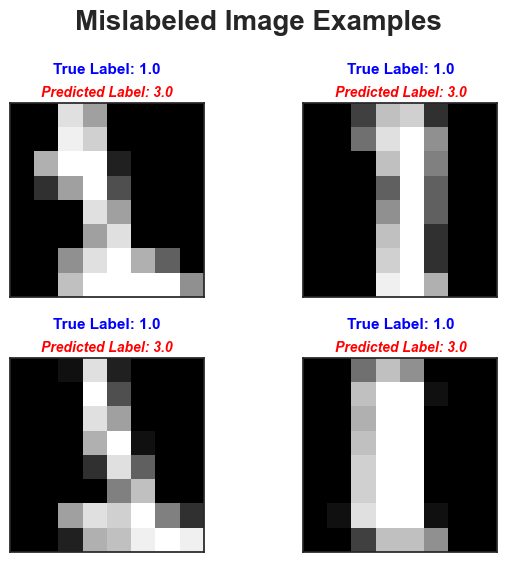

-----------------------------------------------------------------------------------------------------------------------------
True Label: 2
	 Mislabeled Elements: 177
	 Total Elements: 177
	 Label Purity: 0.0000
Mislabeled Elements Frame


index    id  label    id    0    1     2     3     4    5  ...   55   56  \
0      4  1270      2  1270  0.0  2.0  13.0  16.0  10.0  0.0  ...  0.0  0.0   
1      7  1309      2  1309  0.0  0.0   4.0  16.0  16.0  4.0  ...  0.0  0.0   
2      9  1742      2  1742  0.0  4.0  15.0  15.0   8.0  0.0  ...  0.0  0.0   
3     15  1751      2  1751  0.0  0.0  11.0  16.0  10.0  0.0  ...  0.0  0.0   
4     63   408      2   408  0.0  0.0   9.0  11.0   2.0  0.0  ...  0.0  0.0   

    57    58    59    60    61    62   63  predicted_labels  
0  3.0  15.0  16.0  16.0  10.0   1.0  0.0                 3  
1  0.0   5.0  16.0   8.0  11.0  11.0  0.0                 3  
2  7.0  14.0  11.0   0.0   0.0   0.0  0.0                 3  
3  0.0  10.0  13.0   8.0   4.0   1.0  0.0                 3  
4  0.0   7.0   9.0   9.0  12.0   4.0  0.0                 3  

[5 rows x 69 columns]

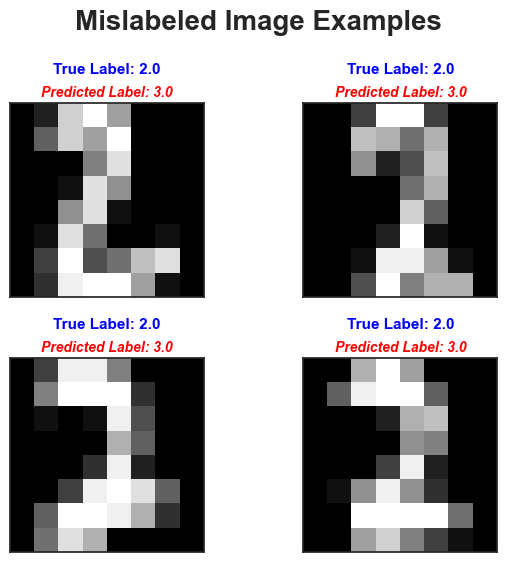

-----------------------------------------------------------------------------------------------------------------------------
True Label: 3
	 Mislabeled Elements: None
	 Total Elements: 183
	 Label Purity: 1.00
-----------------------------------------------------------------------------------------------------------------------------
True Label: 4
	 Mislabeled Elements: 181
	 Total Elements: 181
	 Label Purity: 0.0000
Mislabeled Elements Frame


index    id  label    id    0    1    2     3     4    5  ...   55   56  \
0     12   584      4   584  0.0  0.0  3.0  15.0   6.0  0.0  ...  0.0  0.0   
1     14  1268      4  1268  0.0  0.0  0.0   7.0  14.0  0.0  ...  0.0  0.0   
2     20   497      4   497  0.0  0.0  0.0   2.0  14.0  0.0  ...  0.0  0.0   
3     30   900      4   900  0.0  0.0  0.0   4.0  15.0  6.0  ...  0.0  0.0   
4     33   366      4   366  0.0  0.0  0.0  10.0  14.0  0.0  ...  0.0  0.0   

    57   58    59    60   61   62   63  predicted_labels  
0  0.0  5.0  15.0   4.0  0.0  0.0  0.0                 3  
1  0.0  0.0   9.0  13.0  0.0  0.0  0.0                 3  
2  0.0  0.0   0.0  16.0  6.0  0.0  0.0                 3  
3  0.0  0.0   6.0  16.0  2.0  0.0  0.0                 3  
4  0.0  0.0   8.0  16.0  2.0  0.0  0.0                 3  

[5 rows x 69 columns]

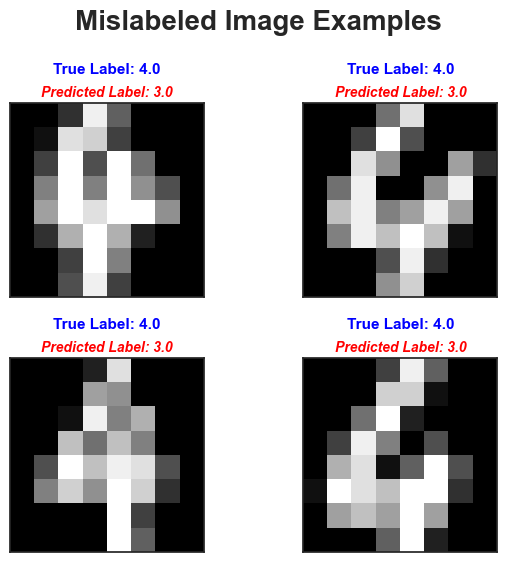

-----------------------------------------------------------------------------------------------------------------------------
True Label: 5
	 Mislabeled Elements: 182
	 Total Elements: 182
	 Label Purity: 0.0000
Mislabeled Elements Frame


index    id  label    id    0    1     2     3     4     5  ...   55   56  \
0      6   692      5   692  0.0  0.0   8.0  12.0  16.0  16.0  ...  0.0  0.0   
1      8  1101      5  1101  0.0  1.0  12.0  16.0  16.0  16.0  ...  0.0  0.0   
2     24  1659      5  1659  0.0  0.0   3.0  14.0  16.0  14.0  ...  0.0  0.0   
3     27   162      5   162  0.0  5.0  16.0  16.0  16.0  11.0  ...  0.0  0.0   
4     49  1333      5  1333  0.0  0.0   9.0  16.0  16.0  16.0  ...  0.0  0.0   

    57    58    59    60   61   62   63  predicted_labels  
0  0.0   9.0  16.0  10.0  0.0  0.0  0.0                 3  
1  2.0  16.0  11.0   0.0  0.0  0.0  0.0                 3  
2  0.0   4.0  16.0   9.0  0.0  0.0  0.0                 3  
3  2.0  15.0  16.0   9.0  0.0  0.0  0.0                 3  
4  0.0  10.0  16.0  16.0  4.0  0.0  0.0                 3  

[5 rows x 69 columns]

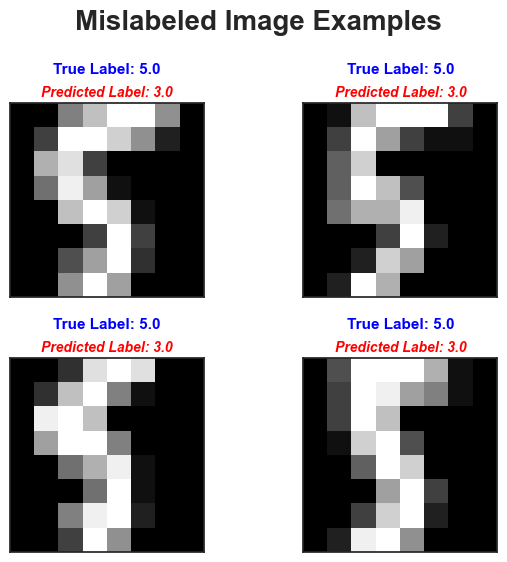

-----------------------------------------------------------------------------------------------------------------------------
True Label: 6
	 Mislabeled Elements: 1
	 Total Elements: 181
	 Label Purity: 0.9945
Mislabeled Elements Frame


index   id  label   id    0    1    2     3     4     5  ...   55   56  \
0   1682  492      6  492  0.0  0.0  0.0  11.0  16.0  12.0  ...  0.0  0.0   

    57   58   59    60   61   62   63  predicted_labels  
0  0.0  1.0  8.0  13.0  0.0  0.0  0.0                 3  

[1 rows x 69 columns]

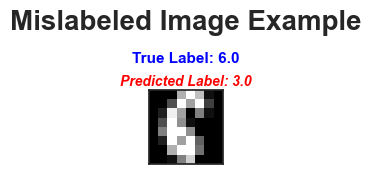

-----------------------------------------------------------------------------------------------------------------------------
True Label: 7
	 Mislabeled Elements: 179
	 Total Elements: 179
	 Label Purity: 0.0000
Mislabeled Elements Frame


index    id  label    id    0    1     2     3     4     5  ...   55   56  \
0      3   438      7   438  0.0  0.0   2.0  12.0  12.0  12.0  ...  0.0  0.0   
1     17   173      7   173  0.0  0.0   7.0  16.0  16.0  16.0  ...  0.0  0.0   
2     23  1586      7  1586  0.0  0.0   8.0  15.0  16.0  10.0  ...  0.0  0.0   
3     38  1200      7  1200  0.0  0.0  12.0  16.0  16.0  12.0  ...  0.0  0.0   
4     66  1121      7  1121  0.0  0.0   4.0  13.0  16.0  16.0  ...  0.0  0.0   

    57    58    59   60   61   62   63  predicted_labels  
0  0.0   3.0  15.0  3.0  0.0  0.0  0.0                 3  
1  0.0   7.0  16.0  3.0  0.0  0.0  0.0                 3  
2  0.0  13.0   1.0  0.0  0.0  0.0  0.0                 3  
3  0.0  16.0   3.0  0.0  0.0  0.0  0.0                 3  
4  0.0   6.0  14.0  0.0  0.0  0.0  0.0                 3  

[5 rows x 69 columns]

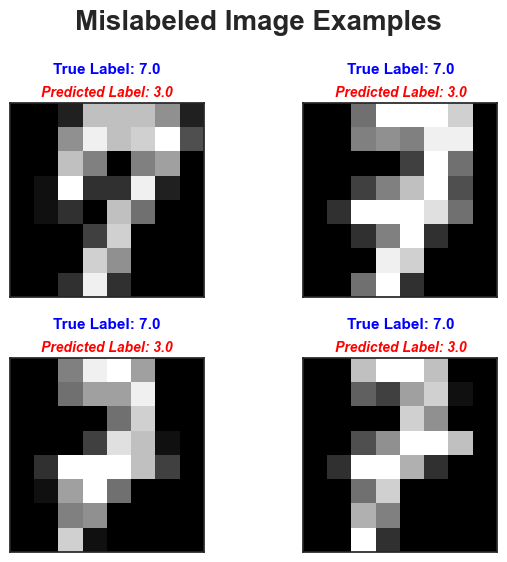

-----------------------------------------------------------------------------------------------------------------------------
True Label: 8
	 Mislabeled Elements: 174
	 Total Elements: 174
	 Label Purity: 0.0000
Mislabeled Elements Frame


index    id  label    id    0    1     2     3     4     5  ...   55   56  \
0     18  1433      8  1433  0.0  0.0   3.0  12.0  15.0  11.0  ...  0.0  0.0   
1     19  1067      8  1067  0.0  1.0  13.0  14.0   2.0   0.0  ...  0.0  0.0   
2     84   332      8   332  0.0  0.0   4.0  13.0  15.0   9.0  ...  0.0  0.0   
3     92   643      8   643  0.0  0.0   0.0   2.0  13.0  13.0  ...  0.0  0.0   
4    118   482      8   482  0.0  0.0   4.0   6.0  11.0   5.0  ...  0.0  0.0   

    57    58    59    60    61    62   63  predicted_labels  
0  0.0   2.0  13.0  16.0  12.0   0.0  0.0                 3  
1  1.0  12.0  14.0  13.0   6.0   0.0  0.0                 3  
2  0.0   2.0  14.0  16.0  15.0   6.0  0.0                 3  
3  0.0   0.0   5.0  10.0  15.0  16.0  0.0                 3  
4  0.0   6.0  10.0  11.0   7.0   1.0  0.0                 3  

[5 rows x 69 columns]

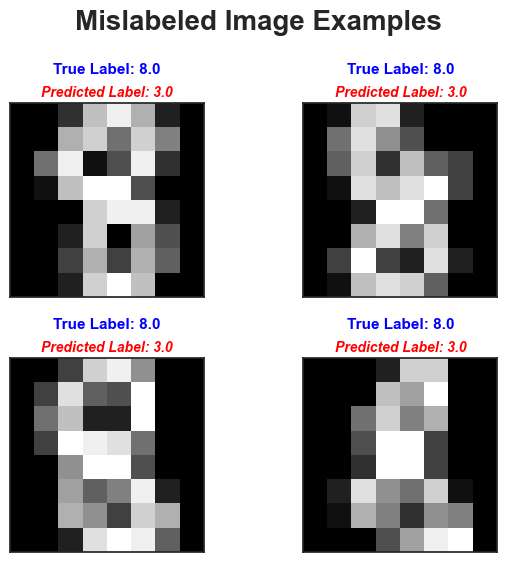

-----------------------------------------------------------------------------------------------------------------------------
True Label: 9
	 Mislabeled Elements: 180
	 Total Elements: 180
	 Label Purity: 0.0000
Mislabeled Elements Frame


index    id  label    id    0    1     2     3     4     5  ...   55   56  \
0      1   220      9   220  0.0  0.0  11.0  16.0   8.0   0.0  ...  0.0  0.0   
1     11   677      9   677  0.0  0.0   0.0   0.0   8.0  14.0  ...  0.0  0.0   
2     22   203      9   203  0.0  0.0  10.0  15.0   7.0   0.0  ...  0.0  0.0   
3     31   415      9   415  0.0  0.0   3.0  14.0  10.0   3.0  ...  0.0  0.0   
4     36  1360      9  1360  0.0  0.0   8.0  16.0   6.0   3.0  ...  0.0  0.0   

    57    58    59    60    61   62   63  predicted_labels  
0  0.0  13.0  16.0  11.0   1.0  0.0  0.0                 3  
1  0.0   0.0   0.0  10.0  10.0  0.0  0.0                 3  
2  1.0  12.0  15.0  12.0   3.0  0.0  0.0                 3  
3  0.0   7.0  12.0  14.0  14.0  6.0  0.0                 3  
4  0.0   6.0  15.0  16.0  10.0  0.0  0.0                 3  

[5 rows x 69 columns]

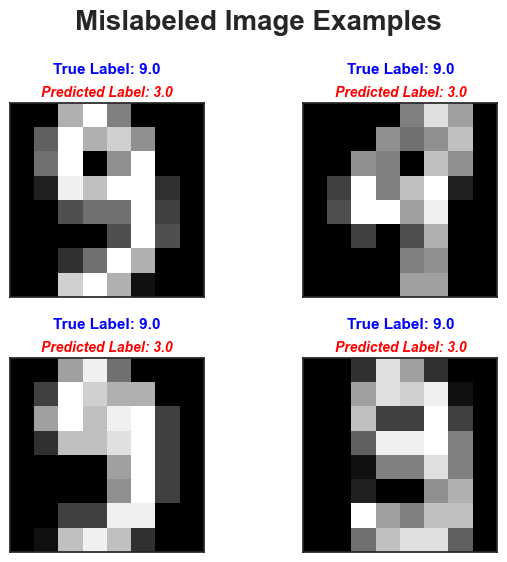

*****************************************************************************************************************************

Examining Predicted Labels Not Presnt in True Labels Set

There no predicted labels that are not in the true labels set.

*****************************************************************************************************************************
****************************************** Results for Manilfold Dimensionality: 2 ******************************************
*****************************************************************************************************************************

Permutations Checked: 1597631/87178291200 (0.00183%) 
-----------------------------------------------------------------------------------------------------------------------------
The Best Contingency Matrix Found by Permuting Predicted Labels: 

[[  0   0   0   0   0   0   0   0   0   0 178   0   0]
 [  0   0   0   0   0   0  27   0  95   0   0   0  57]
 [  0   0   0 1

index    id  label    id    0    1     2     3     4    5  ...   57    58  \
0      5   832      1   832  0.0  0.0  14.0  10.0   0.0  0.0  ...  0.0  12.0   
1     10   787      1   787  0.0  0.0   4.0  12.0  13.0  3.0  ...  0.0   0.0   
2     32  1000      1  1000  0.0  0.0   1.0  14.0   2.0  0.0  ...  0.0   2.0   
3     42   298      1   298  0.0  0.0   7.0  12.0   9.0  0.0  ...  0.0   4.0   
4     51  1040      1  1040  0.0  0.0   6.0  10.0   8.0  3.0  ...  0.0   4.0   

     59    60    61    62    63  predicted_labels         x         y  
0  16.0  16.0  16.0  16.0   9.0                13 -2.953122 -6.156162  
1  15.0  16.0  11.0   0.0   0.0                 8 -4.358406  2.444847  
2  11.0  12.0  15.0  16.0  15.0                13 -2.820568 -6.280789  
3  12.0  12.0   9.0   0.0   0.0                 8 -3.656402  1.964769  
4   9.0  12.0  11.0   2.0   0.0                 8 -3.576545  2.236248  

[5 rows x 71 columns]

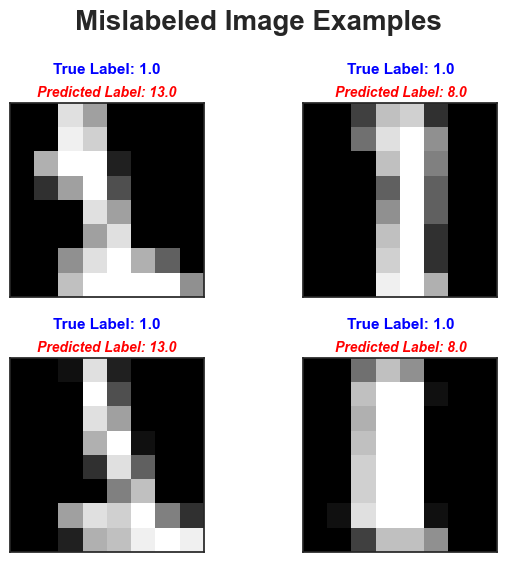

-----------------------------------------------------------------------------------------------------------------------------
True Label: 2
	 Mislabeled Elements: 12
	 Total Elements: 177
	 Label Purity: 0.9322
Mislabeled Elements Frame


index   id  label   id    0    1    2    3     4     5  ...   57   58   59  \
0    116  115      2  115  0.0  0.0  0.0  8.0  15.0   8.0  ...  0.0  0.0  9.0   
1    293   51      2   51  0.0  0.0  0.0  3.0  15.0  10.0  ...  0.0  0.0  4.0   
2    579   54      2   54  0.0  0.0  0.0  1.0  14.0  14.0  ...  0.0  0.0  1.0   
3    909    2      2    2  0.0  0.0  0.0  4.0  15.0  12.0  ...  0.0  0.0  3.0   
4    953   77      2   77  0.0  0.0  0.0  0.0  11.0  15.0  ...  0.0  0.0  1.0   

     60    61    62   63  predicted_labels         x         y  
0  12.0  14.0   4.0  0.0                 8 -2.863216  3.244401  
1   9.0  14.0   7.0  0.0                 8 -2.846951  3.257225  
2  13.0  16.0   5.0  0.0                 8 -2.821057  3.236470  
3  11.0  16.0   9.0  0.0                 8 -2.866995  3.254519  
4  11.0  16.0  12.0  0.0                 8 -2.926607  3.308742  

[5 rows x 71 columns]

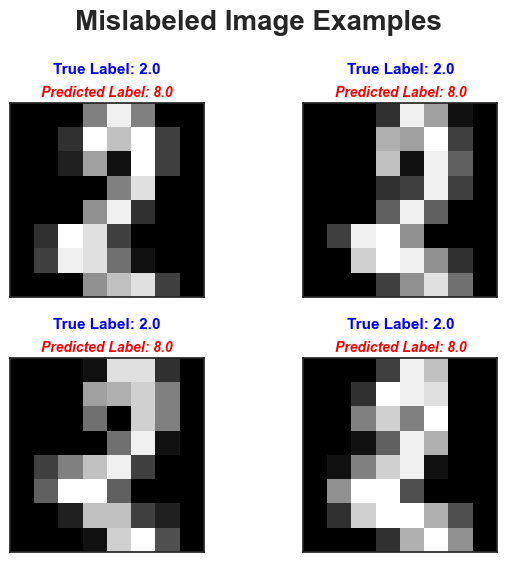

-----------------------------------------------------------------------------------------------------------------------------
True Label: 3
	 Mislabeled Elements: 15
	 Total Elements: 183
	 Label Purity: 0.9180
Mislabeled Elements Frame


index   id  label   id    0    1    2     3     4     5  ...   57   58  \
0     26  619      3  619  0.0  0.0  2.0   9.0  13.0   8.0  ...  0.0  3.0   
1    156  599      3  599  0.0  0.0  1.0   7.0  12.0   3.0  ...  0.0  1.0   
2    390  561      3  561  0.0  0.0  1.0  10.0  15.0  10.0  ...  0.0  2.0   
3    415  529      3  529  0.0  0.0  3.0  10.0  15.0   6.0  ...  0.0  6.0   
4    445  231      3  231  0.0  0.0  5.0  11.0  16.0  16.0  ...  0.0  7.0   

     59    60    61    62   63  predicted_labels         x          y  
0  10.0  14.0  15.0   5.0  0.0                12  0.905025   2.655600  
1   9.0  15.0  16.0  16.0  8.0                12  0.961655   2.610781  
2  11.0  15.0  16.0  12.0  0.0                12  0.952514   2.619811  
3   8.0  16.0  15.0   5.0  0.0                12  0.898019   2.632473  
4  16.0  11.0   2.0   0.0  0.0                 7 -6.601204  10.308977  

[5 rows x 71 columns]

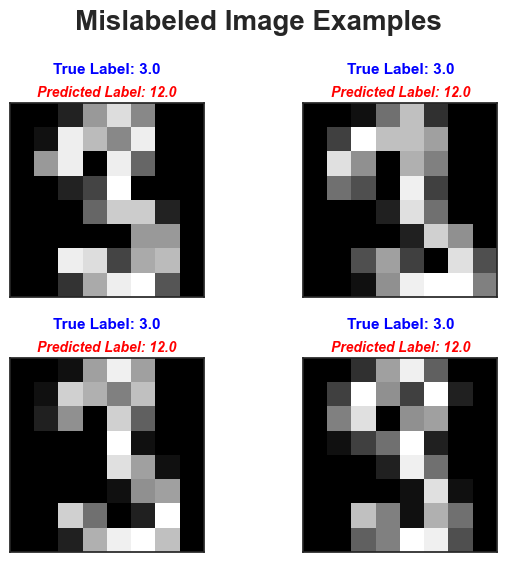

-----------------------------------------------------------------------------------------------------------------------------
True Label: 4
	 Mislabeled Elements: 6
	 Total Elements: 181
	 Label Purity: 0.9669
Mislabeled Elements Frame


index    id  label    id    0    1     2     3     4    5  ...   57    58  \
0   1001   746      4   746  0.0  0.0   1.0  14.0   8.0  8.0  ...  0.0   0.0   
1   1121  1628      4  1628  0.0  0.0   5.0  13.0   0.0  0.0  ...  0.0   6.0   
2   1301  1611      4  1611  0.0  0.0  10.0  14.0   0.0  0.0  ...  0.0  11.0   
3   1603  1660      4  1660  0.0  0.0  11.0   7.0   0.0  0.0  ...  0.0  13.0   
4   1782    87      4    87  0.0  0.0   0.0   9.0  16.0  4.0  ...  0.0   0.0   

     59    60   61   62   63  predicted_labels         x          y  
0  12.0   0.0  0.0  0.0  0.0                 7 -7.454962  11.053507  
1  16.0   1.0  0.0  0.0  0.0                 7 -7.982068  11.375637  
2  12.0   0.0  0.0  0.0  0.0                 7 -7.982372  11.383229  
3  10.0   0.0  0.0  0.0  0.0                 7 -7.989879  11.401579  
4  11.0  13.0  0.0  0.0  0.0                 8 -4.207572   2.645648  

[5 rows x 71 columns]

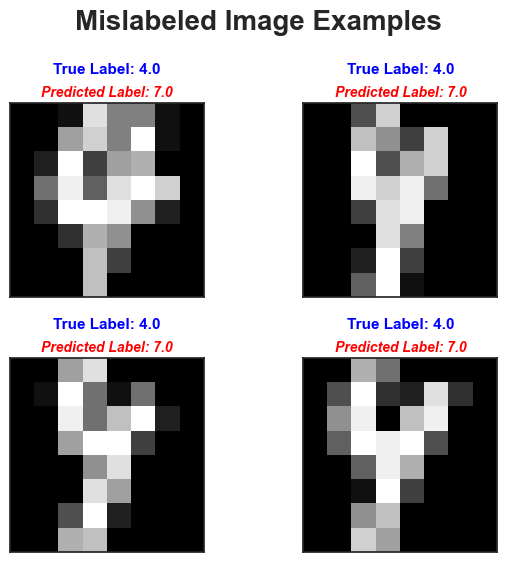

-----------------------------------------------------------------------------------------------------------------------------
True Label: 5
	 Mislabeled Elements: 2
	 Total Elements: 182
	 Label Purity: 0.9890
Mislabeled Elements Frame


index    id  label    id    0    1     2     3     4     5  ...   57   58  \
0    339  1361      5  1361  0.0  0.0   4.0   9.0  13.0  13.0  ...  0.0  3.0   
1    827     5      5     5  0.0  0.0  12.0  10.0   0.0   0.0  ...  0.0  9.0   

     59    60    61   62   63  predicted_labels          x         y  
0  12.0  14.0   8.0  0.0  0.0                 6  14.933546 -4.240447  
1  16.0  16.0  10.0  0.0  0.0                 9   3.551523  2.678799  

[2 rows x 71 columns]

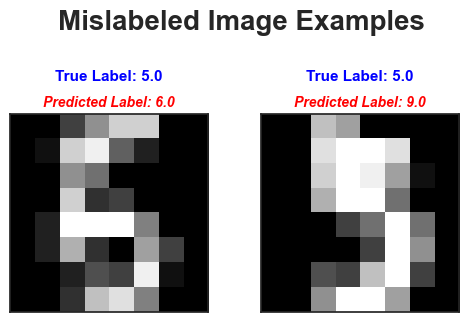

-----------------------------------------------------------------------------------------------------------------------------
True Label: 6
	 Mislabeled Elements: 2
	 Total Elements: 181
	 Label Purity: 0.9890
Mislabeled Elements Frame


index   id  label   id    0    1    2     3     4     5  ...   57   58  \
0   1622   95      6   95  0.0  0.0  0.0  11.0  16.0   8.0  ...  0.0  0.0   
1   1682  492      6  492  0.0  0.0  0.0  11.0  16.0  12.0  ...  0.0  1.0   

     59    60    61   62   63  predicted_labels         x         y  
0  12.0  16.0  15.0  0.0  0.0                 8 -3.698294  1.906868  
1   8.0  13.0   0.0  0.0  0.0                 8 -3.102730  2.316628  

[2 rows x 71 columns]

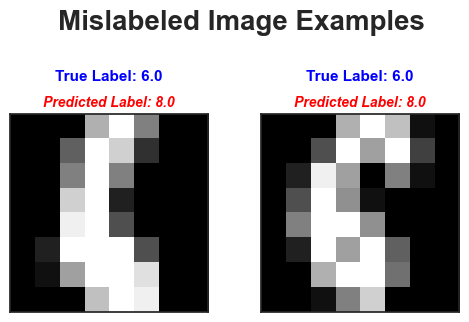

-----------------------------------------------------------------------------------------------------------------------------
True Label: 7
	 Mislabeled Elements: 1
	 Total Elements: 179
	 Label Purity: 0.9944
Mislabeled Elements Frame


index   id  label   id    0    1    2    3     4     5  ...   57   58   59  \
0    133  480      7  480  0.0  0.0  4.0  6.0  11.0  14.0  ...  0.0  0.0  7.0   

     60   61   62   63  predicted_labels         x         y  
0  12.0  0.0  0.0  0.0                11 -4.392098  8.317867  

[1 rows x 71 columns]

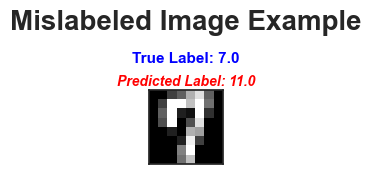

-----------------------------------------------------------------------------------------------------------------------------
True Label: 8
	 Mislabeled Elements: 3
	 Total Elements: 174
	 Label Purity: 0.9828
Mislabeled Elements Frame


index    id  label    id    0    1     2     3     4    5  ...   57    58  \
0   1017   899      8   899  0.0  0.0   6.0  14.0  16.0  5.0  ...  0.0   3.0   
1   1158  1149      8  1149  0.0  0.0  15.0  12.0   3.0  0.0  ...  0.0  15.0   
2   1635   794      8   794  0.0  0.0   0.0   2.0  15.0  5.0  ...  0.0   0.0   

     59    60    61   62   63  predicted_labels         x         y  
0  14.0  16.0   6.0  0.0  0.0                 3  2.441592  0.962798  
1   4.0   5.0  13.0  6.0  0.0                 2 -4.098002 -4.012572  
2   2.0  14.0  11.0  0.0  0.0                 1 -4.194123  4.522605  

[3 rows x 71 columns]

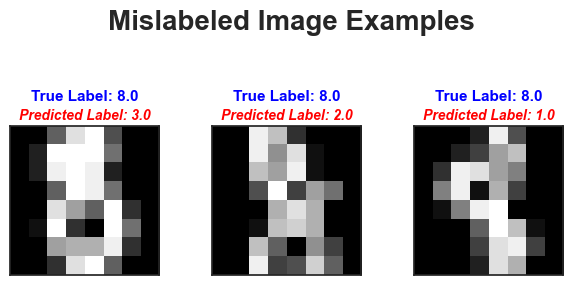

-----------------------------------------------------------------------------------------------------------------------------
True Label: 9
	 Mislabeled Elements: 39
	 Total Elements: 180
	 Label Purity: 0.7833
Mislabeled Elements Frame


index   id  label   id    0    1    2     3     4     5  ...   57   58  \
0     11  677      9  677  0.0  0.0  0.0   0.0   8.0  14.0  ...  0.0  0.0   
1     52  813      9  813  0.0  0.0  3.0   4.0  10.0   0.0  ...  0.0  0.0   
2    107  774      9  774  0.0  0.0  0.0   3.0  12.0  16.0  ...  0.0  0.0   
3    145  381      9  381  0.0  0.0  0.0   2.0   9.0  16.0  ...  0.0  0.0   
4    159   69      9   69  0.0  0.0  6.0  12.0  13.0   6.0  ...  0.0  6.0   

     59    60    61    62   63  predicted_labels         x          y  
0   0.0  10.0  10.0   0.0  0.0                11 -4.742005   7.933257  
1   3.0  11.0  16.0  16.0  3.0                12  0.996315   2.631584  
2   3.0  14.0   1.0   0.0  0.0                11 -4.724237   7.979186  
3   0.0  14.0   4.0   0.0  0.0                11 -4.741395   7.960515  
4  11.0   0.0   0.0   0.0  0.0                 7 -7.995602  11.372819  

[5 rows x 71 columns]

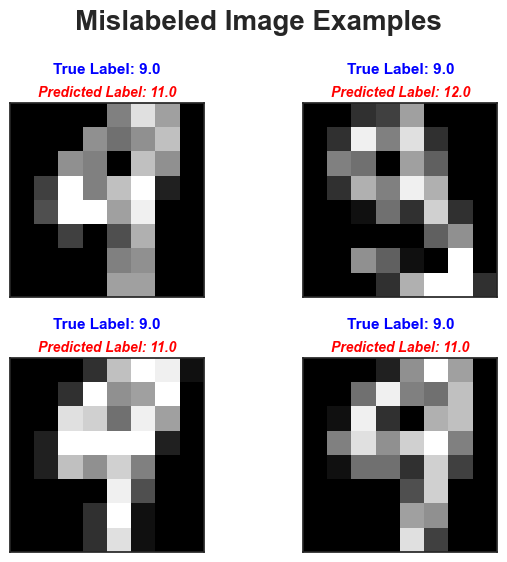

*****************************************************************************************************************************

Examining Predicted Labels Not Presnt in True Labels Set

-----------------------------------------------------------------------------------------------------------------------------
Example Images from Predicted Label: 11


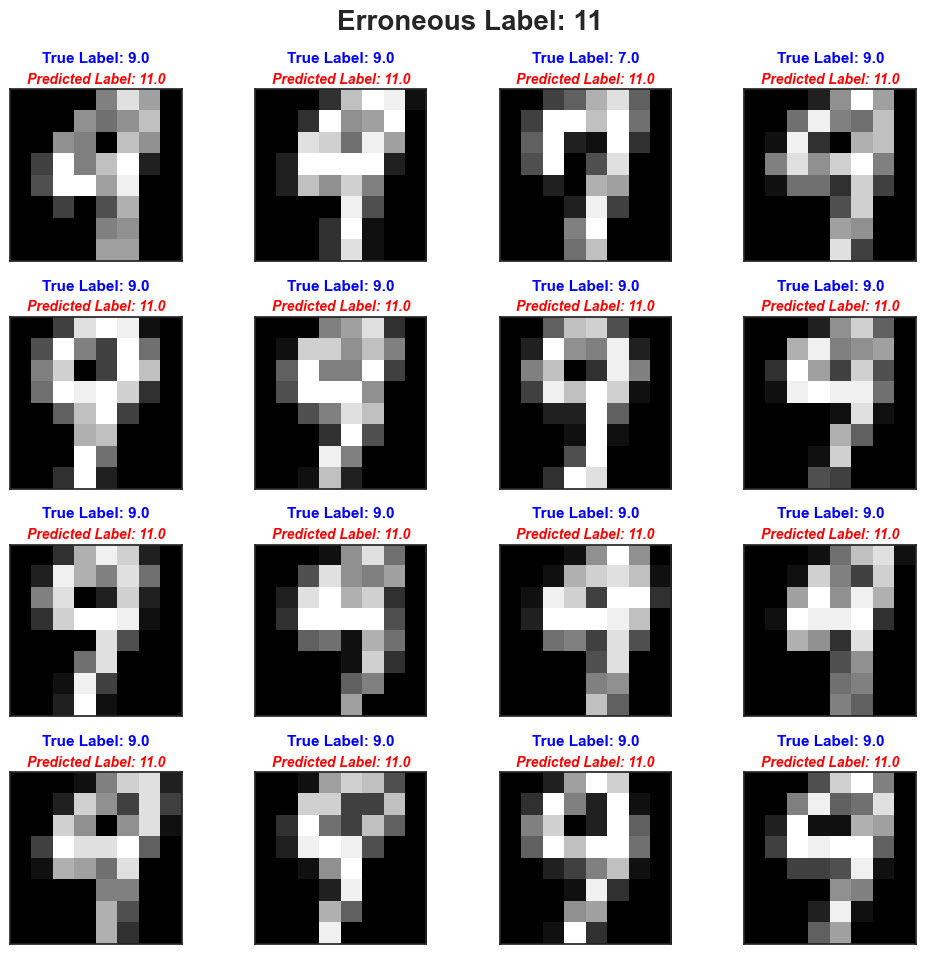

-----------------------------------------------------------------------------------------------------------------------------
Example Images from Predicted Label: 12


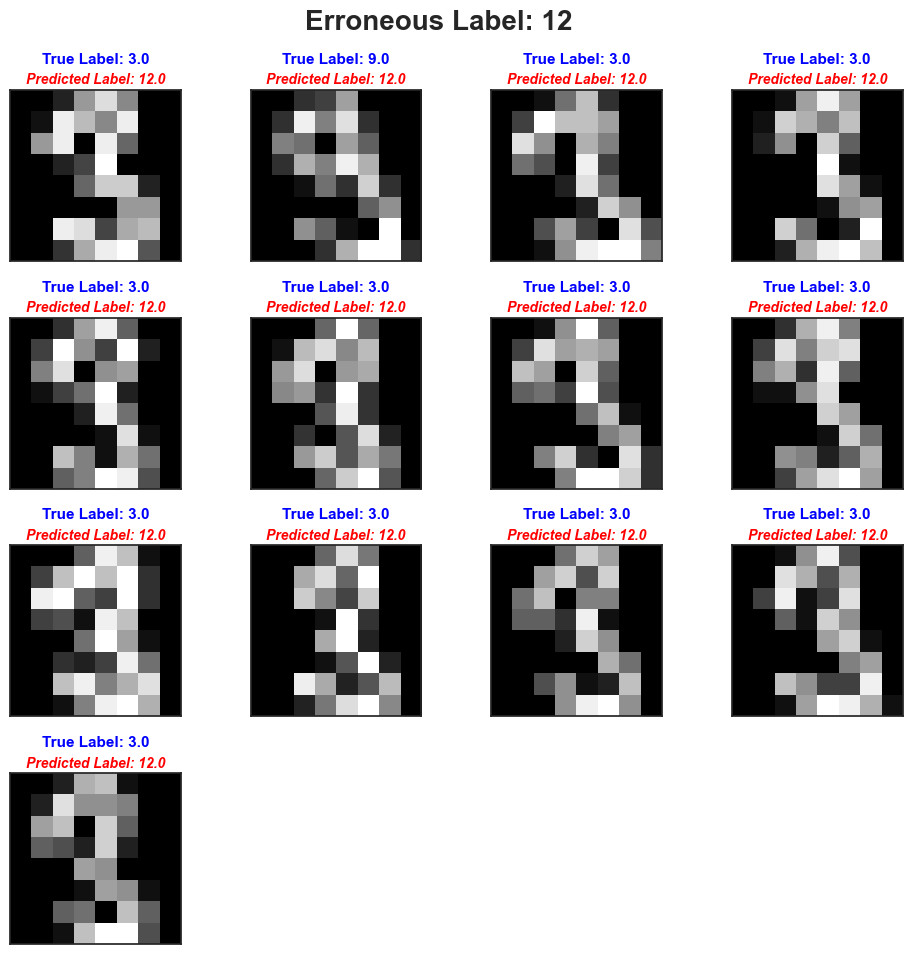

-----------------------------------------------------------------------------------------------------------------------------
Example Images from Predicted Label: 13


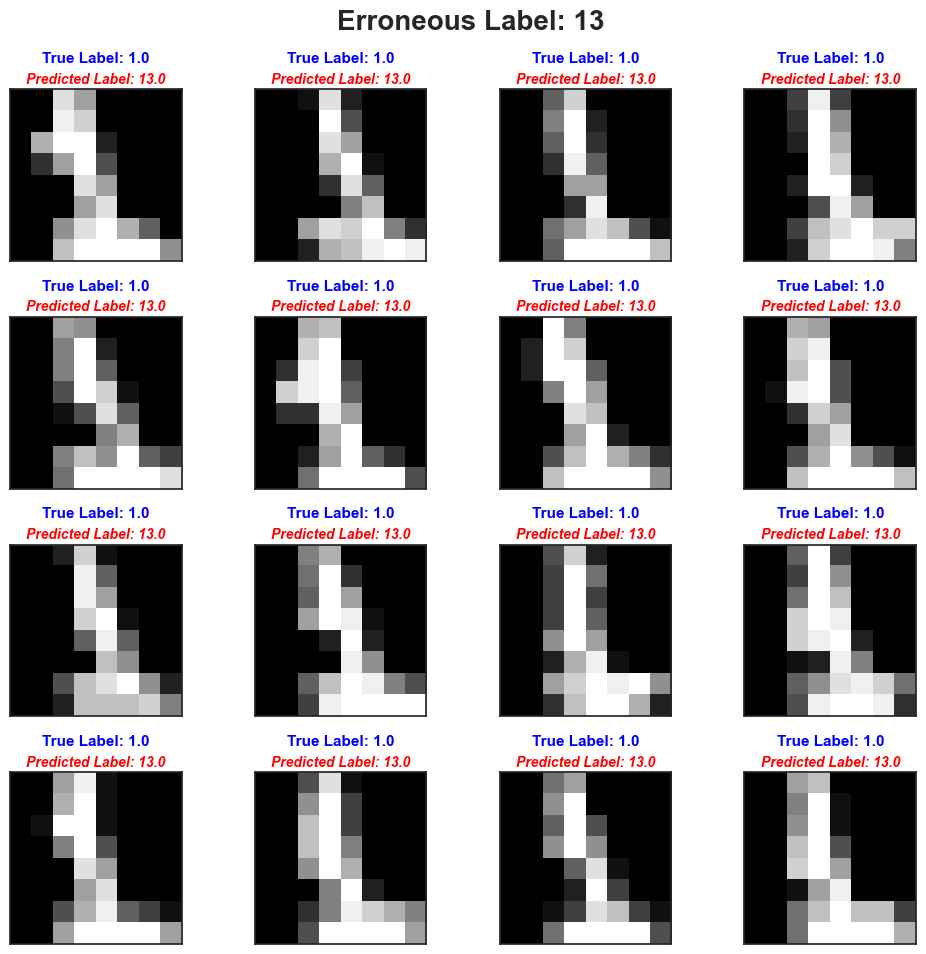

When the Dimensionalty is 2 we can also observe cluster performance with respect to the embedding:



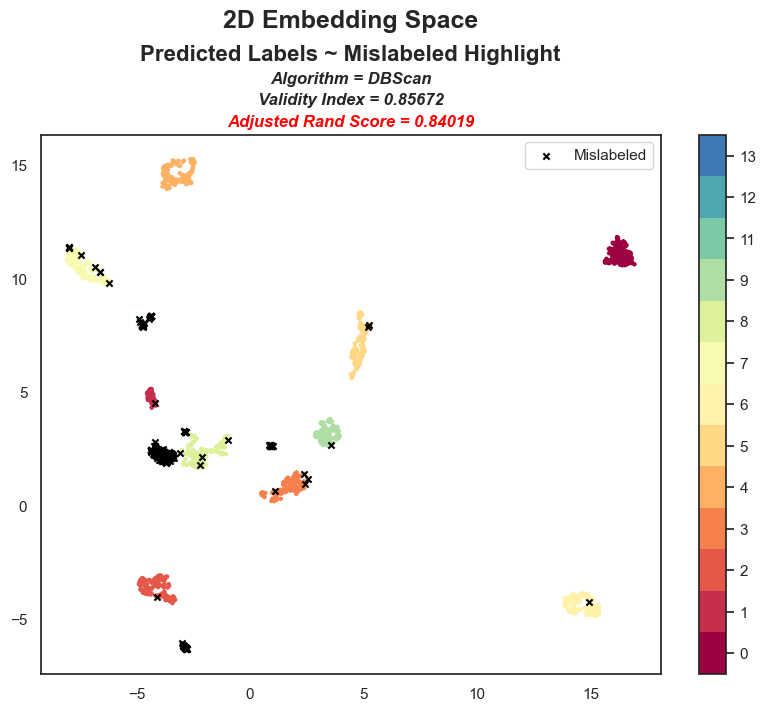

In [30]:
# iterate over the number of embeddings 
for i in range(latent_manifold_details.shape[0]):

        # get the number of components
        num_components = latent_manifold_details.loc[i, 'umap_n_components']

        # extract the cluster labels
        cluster_labels = latent_manifold_details.loc[i, 'cluster_labels']

        # add the labels to the design matrix for plotting
        labels_and_image_data_df = pd.concat([true_labels_df, design_matrix], axis = 1)
        labels_and_image_data_df["predicted_labels"] = cluster_labels

        # this will add the embedding if the n_components = 2, this will used in plotting
        if num_components == 2:
            labels_and_image_data_df = pd.concat([labels_and_image_data_df, n2_embedding_df], axis = 1)

        # this will remove noise labeled elements if DBscan is the cluster algo
        if latent_manifold_details.loc[i, 'algo'] == "DBScan":
            labels_and_image_data_df = labels_and_image_data_df[labels_and_image_data_df['predicted_labels'] != -1]

        # get best contingency matrix by checking all cluster label permutations
        results_dict = get_best_cluster_label_permutation(labels_and_image_data_df['predicted_labels'], labels_and_image_data_df['label'], False, timer)

        # display results
        num_iterations = results_dict['num_iterations']
        possible_iterations = math.factorial(len(np.unique(cluster_labels)))
        percent = (num_iterations/possible_iterations) * 100
        best_c_matrix = results_dict['best_contingency_matrix']
        print("*" * 125)
        print("*" * 42, f"Results for Manilfold Dimensionality: {num_components}", "*" * 42)
        print("*" * 125)
        print()
        print(f"Permutations Checked: {num_iterations}/{possible_iterations} ({percent:.5f}%) ")
        print("-" * 125)
        print(f'The Best Contingency Matrix Found by Permuting Predicted Labels: \n')
        print(best_c_matrix)
        remap_cluster_labels = get_best_mapping_using_mode(labels_and_image_data_df)
        labels_and_image_data_df['predicted_labels'] = labels_and_image_data_df['predicted_labels'].map(remap_cluster_labels)
        labels_and_image_data_df['predicted_labels'] = labels_and_image_data_df['predicted_labels'].astype(int)
        new_contingency_matrix = contingency_matrix(labels_and_image_data_df['label'], labels_and_image_data_df['predicted_labels'])
        print()
        print("*" * 125)

        # the all permutations were not checked
        if percent != 100.0:
            
            # remap cluster labels using the mode
            print()
            print('We can improve this contingency matrix and the mapping using the true label mode with the predicted label.')
            print()
            print('Improved Mapping and Contingency Matrix')
            print()
            remap_cluster_labels = get_best_mapping_using_mode(labels_and_image_data_df)
            labels_and_image_data_df['predicted_labels'] = labels_and_image_data_df['predicted_labels'].map(remap_cluster_labels)
            labels_and_image_data_df['predicted_labels'] = labels_and_image_data_df['predicted_labels'].astype(int)
            new_contingency_matrix = contingency_matrix(labels_and_image_data_df['label'], labels_and_image_data_df['predicted_labels'])
            print(new_contingency_matrix)
            print("*" * 125)

        # generate a list of true labels
        true_labels_list = np.unique(labels_and_image_data_df['label'].values)
        print()
        print("Examining the Mislabeled Images in Each True Class")

        # iterate over true labels to examine mislabeling
        for j in true_labels_list:

            # get the predicted labels
            pred_labels = labels_and_image_data_df.loc[(labels_and_image_data_df['label'] == j)]['predicted_labels'].values

            # generate a df of mislabeled elements
            mislabeled_df = labels_and_image_data_df.loc[(labels_and_image_data_df['label'] == j) & (labels_and_image_data_df['predicted_labels'] != j)]

            # reset the index for plotting
            mislabeled_df.reset_index(inplace = True)

            # get the length of mislabeled df
            num_mislabeled = len(mislabeled_df)

            # get the total elements with true labels
            total_elements_with_true_label = len(labels_and_image_data_df.loc[(labels_and_image_data_df['label'] == j)])

            # check if there are mislabeled elements
            print("-" * 125)
            if num_mislabeled == 0:

                # print results
                print(f'True Label: {j}')
                print(f'\t Mislabeled Elements: None')
                print(f'\t Total Elements: {total_elements_with_true_label}')
                print(f'\t Label Purity: 1.00')
                continue
            else:

                # print results
                print(f'True Label: {j}')
                print(f'\t Mislabeled Elements: {num_mislabeled}')
                print(f'\t Total Elements: {total_elements_with_true_label}')
                print(f'\t Label Purity: {((total_elements_with_true_label - num_mislabeled)/total_elements_with_true_label):.4f}')

                # display frame containing mislabeled elements
                print(f'Mislabeled Elements Frame')
                display(mislabeled_df.head())

                # display example images of mislabeled images
                plot_mislabeled_examples(mislabeled_df, num_mislabeled, num_components, j, path)
        
        # examine the predicted labels that are not present in the true label set
        print("*" * 125)
        print()
        print("Examining Predicted Labels Not Presnt in True Labels Set")
        print()
            
        # generate a list predicted labels that are not in the true labels set
        erroneous_labels_list = [x for x in labels_and_image_data_df.predicted_labels.unique() if x not in labels_and_image_data_df.label.unique()]
        erroneous_labels_list.sort()

        if erroneous_labels_list != []:
            plot_erroneous_label_examples(labels_and_image_data_df, erroneous_labels_list, num_components, path)
        else:
             print("There no predicted labels that are not in the true labels set.")
             print()

        # if embedding is 2D, generate a plot of embedding with cluster results
        if num_components == 2:
                print('When the Dimensionalty is 2 we can also observe cluster performance with respect to the embedding:')
                print()
                validity_index = results_tabulation[results_tabulation['umap_n_components'] == 2].validity_index.values[0]
                algo = results_tabulation[results_tabulation['umap_n_components'] == 2].algo.values[0]
                adjusted_rand = results_tabulation[results_tabulation['umap_n_components'] == 2].adj_rand_score.values[0]
                plot_2D_embedding_with_cluster_label_results(labels_and_image_data_df, algo, validity_index, adjusted_rand, path)